In [1]:
import pandas as pd
import numpy as np

import simfin as sf
from simfin.names import *

import matplotlib.pyplot as plt

In [2]:
sf.set_data_dir('simfin_data/')
sf.set_api_key(api_key='free')

In [3]:
df_prices = sf.load_shareprices(variant='daily', market='us')

Dataset "us-shareprices-daily" on disk (1 days old).
- Loading from disk ... Done!


In [4]:
df_prices.loc['MSFT'].head()

,SimFinId,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
Date,,,,,,,,,
2007-01-03,59265,29.91,29.40,30.25,29.86,21.91,NaN,76935100,NaN
2007-01-04,59265,29.70,29.44,29.97,29.81,21.88,NaN,45774500,NaN
2007-01-05,59265,29.63,29.45,29.75,29.64,21.75,NaN,44607200,NaN
2007-01-08,59265,29.65,29.53,30.10,29.93,21.96,NaN,50220200,NaN
2007-01-09,59265,30.00,29.73,30.18,29.96,21.99,NaN,44636600,NaN


In [5]:
portfolio_composition = [('MSFT',0.5),('AAPL',0.2),('GOOG',0.3)]

returns = pd.DataFrame({})

In [6]:
for t in portfolio_composition:
    
    name = t[0]
    data = df_prices.loc[name]
    data[f'return_{name}'] = data['Adj. Close'].pct_change(1)

    returns = returns.join(data[[f'return_{name}']],how='outer').dropna()

/Users/khor.eanyee/miniconda3/envs/simfin/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [7]:
returns

,return_MSFT,return_AAPL,return_GOOG
Date,,,
2014-03-28,0.023726,-0.001165,0.002740
2014-03-31,0.017167,0.000000,-0.005393
2014-04-01,0.010408,0.009329,0.018295
2014-04-02,-0.001670,0.001155,-0.000282
2014-04-03,-0.008087,-0.006924,0.004832
...,...,...,...
2020-07-13,-0.030859,-0.004618,-0.019718
2020-07-14,0.006144,0.016556,0.006114
2020-07-15,-0.001454,0.006950,-0.004564


## What if analysis

Scenario analysis can be performed to know what happens if certain conditions will occur. 

In [8]:
def simulate_modified_returns(historical_returns, forecast_days, correct_mean_by):

    h = historical_returns.copy()
    new_series = h + correct_mean_by

    return new_series.sample(n=forecast_days,replace=True).reset_index(drop=True)

In [9]:
def simulate_modified_portfolio(ticker, portfolio_composition, historical_returns, forecast_days):
    
    name = ticker
    weight = portfolio_composition[name]['weight']
    correction = portfolio_composition[name]['correction']
    s = simulate_modified_returns(historical_returns[f'return_{name}'], forecast_days, correction)
    s = s * weight
  
    return s

In [10]:
def simulation(ticker, portfolio_composition, historical_returns,forecast_days,n_iterations):
    simulated_portfolios = None

    for i in range(n_iterations):
        sim = simulate_modified_portfolio(ticker, portfolio_composition, historical_returns, forecast_days)

        sim_port = pd.DataFrame({'returns_%d' % (i) : sim})

        if simulated_portfolios is None:
            simulated_portfolios = sim_port
        else:
            simulated_portfolios = simulated_portfolios.join(sim_port)
    
    return simulated_portfolios

## Simulation with what if analysis

Let’s try to simulate what happens if the average returns drop by -0.0001 for MSFT, -0.001 for AAPL and -0.0005 for GOOG. We must subtract these quantities from each stock and then simulate the future portfolios with the new, modified data.

### 1. Confidence interval for future portfolios

5th percentile of the future cumulative return: There is a 5% chance that our portfolio will underperform this value
95th percentile of the future cumulative return: There is a 5% chance your portfolio will outperform this value

We also want to check how the average portfolio will perform.

### 2. Probability of reaching a target return

An analysis to determine the probability that our portfolio will outperform a target return as a function of the day in the future.

### 3. Expected value and histogram of Sharpe ratio

In [11]:
returns.mean(axis=0)

return_MSFT    0.001257
return_AAPL    0.001234
return_GOOG    0.000764
dtype: float64

In [12]:
portfolio_composition = dict()

portfolio_composition['MSFT']={'weight':0.5,
                               'correction':-0.0001}

portfolio_composition['AAPL']={'weight':0.2,
                               'correction':-0.001}

portfolio_composition['GOOG']={'weight':0.3,
                               'correction':-0.0005}

In [13]:
portfolio_composition

{'MSFT': {'weight': 0.5, 'correction': -0.0001},
 'AAPL': {'weight': 0.2, 'correction': -0.001},
 'GOOG': {'weight': 0.3, 'correction': -0.0005}}

In [14]:
FORECAST_DAYS = 20
N_ITERATIONS = 200

In [15]:
def get_ci(simulated_portfolio):
    
    percentile_5th = simulated_portfolio.cumsum().apply(lambda x : np.percentile(x,5),axis=1)
    percentile_95th = simulated_portfolio.cumsum().apply(lambda x : np.percentile(x,95),axis=1)
    average_port = simulated_portfolio.cumsum().apply(lambda x : np.mean(x),axis=1)
    
    return percentile_5th, percentile_95th, average_port

def get_prob(simulated_portfolio, n_iterations, target_return=0.02):
    
    target_prob_port = simulated_portfolio.cumsum().apply(lambda x : np.mean(x > target_return),axis=1)
    err_bars = np.sqrt(target_prob_port*(1-target_prob_port)/n_iterations)
    
    return target_prob_port, err_bars

def get_sharpe(simulated_portfolio):
    
    sharpe_indices = simulated_portfolio.apply(lambda x : np.mean(x)/np.std(x))
    sharpe_mean = np.mean(sharpe_indices)
    
    return sharpe_indices, sharpe_mean

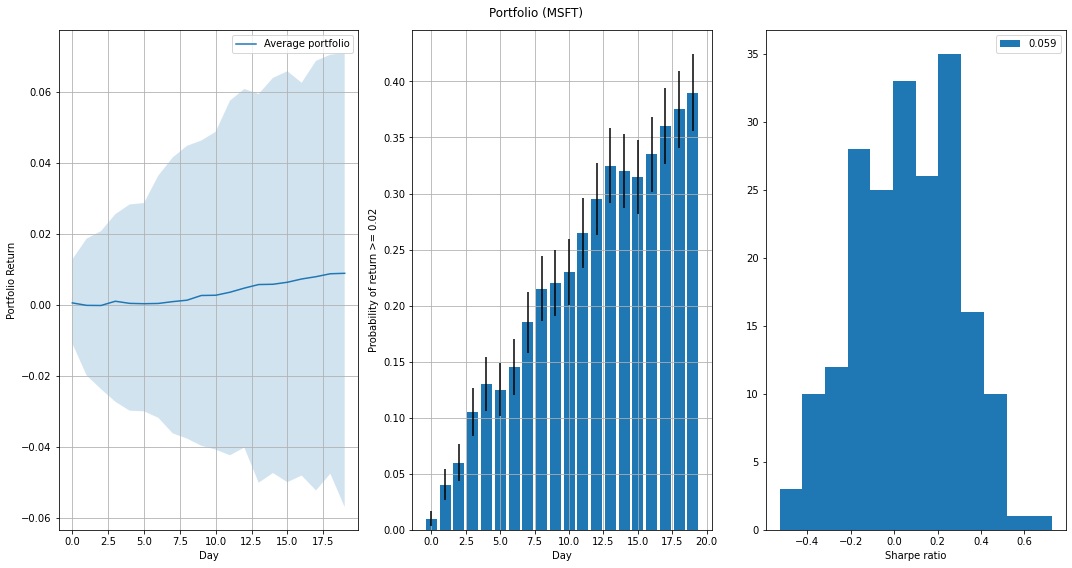

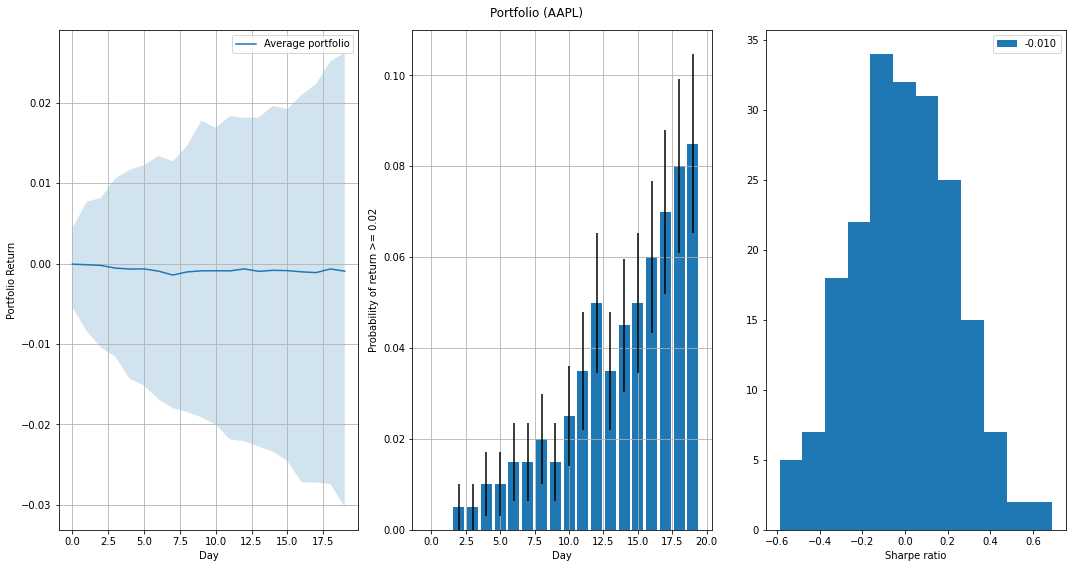

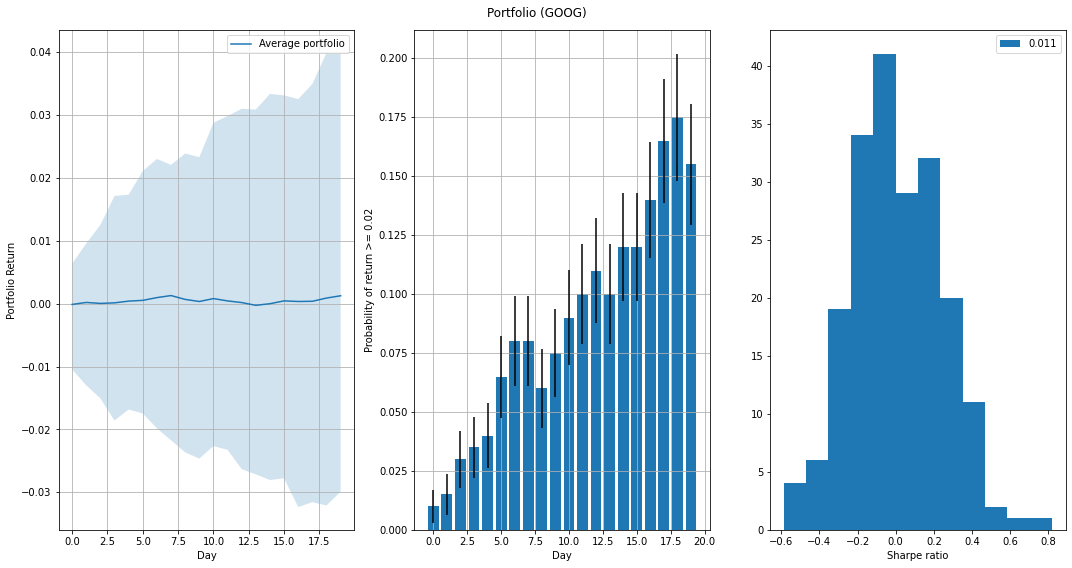

In [17]:
for ticker in portfolio_composition.keys():

    simulated_portfolio = simulation(ticker, portfolio_composition, returns, 
                                     forecast_days=FORECAST_DAYS, n_iterations=N_ITERATIONS)
    
    # Confidence interval for future portfolios
    percentile_5th, percentile_95th, average_port = get_ci(simulated_portfolio)
    
    # Probability of beating the portfolio target
    target_return = 0.02
    target_prob_port, err_bars = get_prob(simulated_portfolio, n_iterations=N_ITERATIONS, target_return=0.02)
    
    # Sharpe ratio histogram
    sharpe_indices, sharpe_mean = get_sharpe(simulated_portfolio)
    
    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(15,8))
    
    x = range(FORECAST_DAYS)

    ax[0].plot(x,average_port,label='Average portfolio')
    ax[0].set_xlabel('Day')
    ax[0].set_ylabel('Portfolio Return')

    ax[0].fill_between(x, percentile_5th, percentile_95th,alpha=0.2)
    ax[0].grid()
    ax[0].legend()
    
    ax[1].bar(x,target_prob_port,yerr = err_bars)
    ax[1].set_xlabel('Day')
    ax[1].set_ylabel('Probability of return >= %.2f' % (target_return))
    ax[1].grid()
    
    ax[2].hist(sharpe_indices,bins='rice', label='%.3f' % (sharpe_mean))
    ax[2].set_xlabel('Sharpe ratio')
    ax[2].legend()
    
    plt.suptitle(f'Portfolio ({ticker})')
    plt.tight_layout()
    plt.show()

## Observations

Take MSFT as an example:

**1. Confidence interval for future portfolios**

After 20 days there is a 5% probability that our portfolio will lose 6% (lower band) and there is a 5% probability that our portfolio return will be greater than 7% (upper band). On average, we expect our portfolio to have a 1% return (solid line).

**2. Probability of reaching a target return**

The probability of overperforming our target return (i.e. 2% in this case) increases with time (that’s obviously true since our portfolio has a positive average return). After 20 days, our portfolio will outperform the 2% target with a 45 +/- 2.3% probability.

---

# Archieve


## Monte Carlo simulation of a portfolio

1. A very simple simulation where the future returns are a random sample of the past returns.

2. A portfolio is a combination of returns and weights (i.e. the weighted sum of the stock returns).

In [ ]:
def simulate_returns(historical_return,forecast_days):
    
    return historical_return.sample(n = forecast_days, replace = True).reset_index(drop = True)

In [ ]:
simulate_returns(returns['return_MSFT'],forecast_days=10)

In [ ]:
def simulate_portfolio(historical_returns,composition,forecast_days):

    for idx, t in enumerate(composition):
        name, weight = t[0], t[1]
        s = simulate_returns(historical_returns[f'return_{name}'], forecast_days)
        s = s * weight
        
        if idx==0:
            df_result = s
        
        else:
            df_result = pd.concat([df_result, s], axis=1)
        
    return df_result

In [ ]:
df_result = simulate_portfolio(returns,portfolio_composition,10)

In [ ]:
df_result

---

## Reference

https://github.com/gianlucamalato/machinelearning/blob/master/Portfolio_scenario_analysis.ipynb